In [0]:
#Domain Adversarial Network
#Reference: https://github.com/ShichengChen/Domain-Adversarial-Training-of-Neural-Networks
#Reference: https://github.com/CuthbertCai/pytorch_DANN

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%cd drive/My Drive/Deep_Learning/Assignment_3/dann/
!ls

/content/drive/My Drive/Deep_Learning/Assignment_3/dann
Code_DANN.ipynb   dla3try_code.ipynb  mnist_m	      model_dann_mode.pt
DANN_Model.ipynb  MNIST		      mnist_m.tar.gz


In [0]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import torch.utils.data as utils
import time
import os
import torch.nn as nn
from torch.autograd import Function
import torchvision
import torch.utils.data as data
from PIL import Image
import os

In [0]:
class GRL(Function):
    @staticmethod
    def forward(ctx, x, constant):
        ctx.constant = constant
        return x.view_as(x) * constant
    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.constant, None

In [0]:
class Dann(nn.Module):
    def __init__(self):
        super(Dann, self).__init__()
        self.f = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=5),
                nn.BatchNorm2d(64),
                nn.MaxPool2d(2),
                nn.ReLU(True),

                nn.Conv2d(64, 50, kernel_size=5),
                nn.BatchNorm2d(50),
                nn.Dropout2d(),
                nn.MaxPool2d(2),
                nn.ReLU(True),
            )
        self.lc = nn.Sequential(
            nn.Linear(50*4*4, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(True),
            nn.Dropout2d(),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(True),
            nn.Linear(100, 10),
            nn.LogSoftmax(),
        )
        self.dc = nn.Sequential(
            nn.Linear(50 * 4 * 4, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(True),
            nn.Linear(100, 2),
            nn.LogSoftmax(dim=1),
        )
    def forward(self, x,alpha):
        x = self.f(x)
        x = x.view(-1, 50*4*4)
        y = GRL.apply(x, alpha)
        x = self.lc(x)
        y = self.dc(y)
        x=x.view(x.shape[0],-1)
        y=y.view(y.shape[0],-1)
        return x, y

In [0]:
source_train = torch.utils.data.DataLoader(
        datasets.MNIST('./', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.5,), (0.5,)),
                           transforms.Lambda(lambda x: x.repeat(3, 1, 1))
                       ])),
        batch_size=512, shuffle=True,num_workers=12)
source_test = torch.utils.data.DataLoader(
        datasets.MNIST('./', train=False, download=True, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.5,), (0.5,)),
                           transforms.Lambda(lambda x: x.repeat(3, 1, 1))
                       ])),
        batch_size=512, shuffle=False,num_workers=12)

In [0]:
#unzip mnist_m
!tar -xvf "mnist_m.tar.gz"

Streaming output truncated to the last 5000 lines.
mnist_m/mnist_m_test/00004544.png
mnist_m/mnist_m_test/00000258.png
mnist_m/mnist_m_test/00004074.png
mnist_m/mnist_m_test/00006977.png
mnist_m/mnist_m_test/00004200.png
mnist_m/mnist_m_test/00005651.png
mnist_m/mnist_m_test/00008563.png
mnist_m/mnist_m_test/00008032.png
mnist_m/mnist_m_test/00003311.png
mnist_m/mnist_m_test/00003541.png
mnist_m/mnist_m_test/00003759.png
mnist_m/mnist_m_test/00005223.png
mnist_m/mnist_m_test/00008205.png
mnist_m/mnist_m_test/00007685.png
mnist_m/mnist_m_test/00005618.png
mnist_m/mnist_m_test/00001756.png
mnist_m/mnist_m_test/00005528.png
mnist_m/mnist_m_test/00008606.png
mnist_m/mnist_m_test/00005159.png
mnist_m/mnist_m_test/00005128.png
mnist_m/mnist_m_test/00001825.png
mnist_m/mnist_m_test/00001524.png
mnist_m/mnist_m_test/00003892.png
mnist_m/mnist_m_test/00006887.png
mnist_m/mnist_m_test/00007919.png
mnist_m/mnist_m_test/00005374.png
mnist_m/mnist_m_test/00000191.png
mnist_m/mnist_m_test/00001185.p

In [0]:
class GetLoader(data.Dataset):
    def __init__(self, data_root, data_list, transform=None):
        self.root = data_root
        self.transform = transform

        f = open(data_list, 'r')
        data_list = f.readlines()
        f.close()

        self.n_data = len(data_list)

        self.img_paths = []
        self.img_labels = []

        for data in data_list:
            self.img_paths.append(data[:-3])
            self.img_labels.append(data[-2])

    def __getitem__(self, item):
        img_paths, labels = self.img_paths[item], self.img_labels[item]
        imgs = Image.open(os.path.join(self.root, img_paths)).convert('RGB')

        if self.transform is not None:
            imgs = self.transform(imgs)
            labels = int(labels)

        return imgs, labels

    def __len__(self):
        return self.n_data

In [0]:
image_size=28
img_transform = transforms.Compose([
    transforms.RandomCrop((image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,0.5,0.5),
                         std=(0.5,0.5,0.5))
])
train_list = os.path.join('mnist_m', 'mnist_m_train_labels.txt')
dataset_train_target = GetLoader(
    data_root=os.path.join('mnist_m', 'mnist_m_train'),
    data_list=train_list,
    transform=img_transform
)
test_list = os.path.join('mnist_m', 'mnist_m_test_labels.txt')
dataset_test_target = GetLoader(
    data_root=os.path.join('mnist_m', 'mnist_m_test'),
    data_list=test_list,
    transform=img_transform
)
target_train = torch.utils.data.DataLoader(dataset_train_target,batch_size=512, shuffle=True,num_workers=12)
target_test = torch.utils.data.DataLoader(dataset_test_target,batch_size=512, shuffle=True,num_workers=12)

In [0]:
device='cuda'
model = Dann().to(device)

#optimizer = optim.Adam(model.parameters(),weight_decay=1e-5)
optimizer = optim.SGD(model.parameters(), lr= 0.01, momentum= 0.9)
#optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
criterion = nn.CrossEntropyLoss()

def optimizer_scheduler(optimizer, p):
    for param_group in optimizer.param_groups:
        param_group['lr'] = 0.01 / (1. + 10 * p) ** 0.75
    return optimizer

In [0]:
def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in source_test:
            data, target = data.to(device), target.to(device)
            output, _ = model(data,0.5)
            test_loss += float(criterion(output, target))  # sum up batch loss
            pred = output.max(1, keepdim=True)[1]  # get the index of the max log-probability
            correct += float(pred.eq(target.view_as(pred)).sum())

    test_loss /= len(source_test.dataset)
    print('Test set on Source Domain: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(source_test.dataset),
        100. * correct / len(source_test.dataset)))

    # model.eval()
    # test_loss = 0
    # correct = 0
    # with torch.no_grad():
    #     for data, target in target_train:
    #         data, target = data.to(device), target.to(device)
    #         output, _ = model(data,0.5)
    #         test_loss += float(criterion(output, target))  # sum up batch loss
    #         pred = output.max(1, keepdim=True)[1]  # get the index of the max log-probability
    #         correct += float(pred.eq(target.view_as(pred)).sum())

    # test_loss /= len(target_train.dataset)
    # print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    #     test_loss, correct, len(target_train.dataset),
    #     100. * correct / len(target_train.dataset)))
    
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in target_test:
            data, target = data.to(device), target.to(device)
            output, _ = model(data,0.5)
            test_loss += float(criterion(output, target))  # sum up batch loss
            pred = output.max(1, keepdim=True)[1]  # get the index of the max log-probability
            correct += float(pred.eq(target.view_as(pred)).sum())

    test_loss /= len(target_test.dataset)
    print('Test set on Target Domain: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(target_test.dataset),
        100. * correct / len(target_test.dataset)))

In [0]:
print(len(target_train),len(source_train))

116 118


In [0]:
allepoch=50

for epoch in range(allepoch):
    len_dataloader = min(len(source_train), len(target_train))
    total_steps = allepoch * len(source_train)
    i = 0
    model.train()
    start_time = time.time()
    for batch_idx, (data_source, data_target) in enumerate(zip(source_train, target_train)):
        s_img, s_label = data_source
        t_img, _ = data_target
        start_steps = epoch * len(source_train)

        p = float(i + start_steps) / total_steps
        alpha = 2. / (1. + np.exp(-10 * p)) - 1

        class_pred,domain_pred = model(s_img.to(device),alpha)
        err_s_label = criterion(class_pred, s_label.to(device))

        batch_size = len(s_label)
        domain_label = torch.zeros(batch_size)
        domain_label = domain_label.long()
        err_s_domain = criterion(domain_pred, domain_label.to(device))

        _,domain_pred = model(t_img.to(device),alpha)

        batch_size = len(t_img)
        domain_label = torch.ones(batch_size)
        domain_label = domain_label.long()
        err_t_domain = criterion(domain_pred, domain_label.to(device))

        err = err_s_label + err_s_domain + err_t_domain

        optimizer = optimizer_scheduler(optimizer, p)
        optimizer.zero_grad()

        err.backward()
        optimizer.step()

        if(i % 100 == 0):
            print('epoch:{},[{}/{}],s_label:{:.3f},time{}'.
                      format(epoch, i, len_dataloader, float(err_s_label), time.time() - start_time))
        i += 1
    test(epoch)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


epoch:0,[0/116],s_label:2.326,time29.908466577529907
epoch:0,[100/116],s_label:0.383,time248.38062071800232
Test set on Source Domain: Average loss: 0.0003, Accuracy: 9574.0/10000 (96%)
Test set on Target Domain: Average loss: 0.0034, Accuracy: 3974.0/9001 (44%)

epoch:1,[0/116],s_label:0.339,time28.729458570480347
epoch:1,[100/116],s_label:0.279,time247.56749939918518
Test set on Source Domain: Average loss: 0.0002, Accuracy: 9702.0/10000 (97%)
Test set on Target Domain: Average loss: 0.0034, Accuracy: 3883.0/9001 (43%)

epoch:2,[0/116],s_label:0.181,time29.918953895568848
epoch:2,[100/116],s_label:0.198,time252.10731744766235
Test set on Source Domain: Average loss: 0.0002, Accuracy: 9746.0/10000 (97%)
Test set on Target Domain: Average loss: 0.0033, Accuracy: 4083.0/9001 (45%)

epoch:3,[0/116],s_label:0.153,time29.298149347305298
epoch:3,[100/116],s_label:0.157,time248.93709325790405
Test set on Source Domain: Average loss: 0.0001, Accuracy: 9788.0/10000 (98%)
Test set on Target Dom

In [0]:
#Save the weights of trained model
torch.save(model.state_dict(), 'model_dann_mode.pt')

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


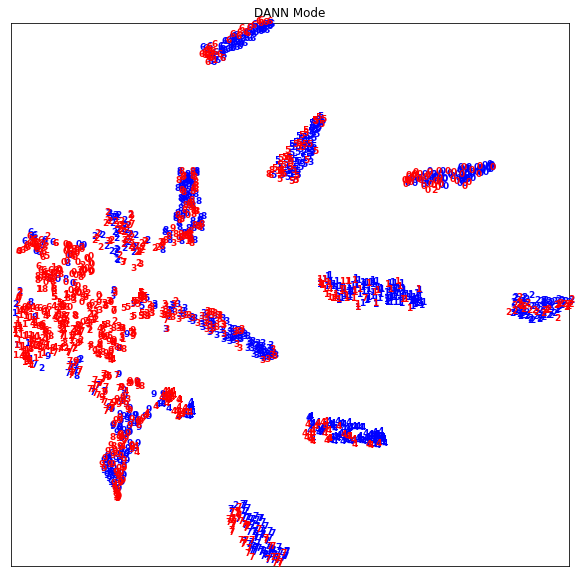

In [0]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Setup the network
model.eval()

# Randomly select samples from source domain and target domain.
num_of_samples = 1000
use_gpu = True
# Collect source data.
s_images, s_labels, s_tags = [], [], []
for images, labels in source_test:
  s_images.append(images.cuda())
  s_labels.append(labels)
  s_tags.append(torch.zeros((labels.size()[0])).type(torch.LongTensor))
  if len(s_images * batch_size) > num_of_samples:
    break
s_images, s_labels, s_tags = torch.cat(s_images)[:num_of_samples],torch.cat(s_labels)[:num_of_samples], torch.cat(s_tags)[:num_of_samples]


# Collect test data.
t_images, t_labels, t_tags = [], [], []
for images, labels in target_test:
  if use_gpu:
    t_images.append(images.cuda())
  else:
    t_images.append(images)
  t_labels.append(labels)
  t_tags.append(torch.ones((labels.size()[0])).type(torch.LongTensor))
  if len(t_images * batch_size) > num_of_samples:
    break
t_images, t_labels, t_tags = torch.cat(t_images)[:num_of_samples], torch.cat(t_labels)[:num_of_samples], torch.cat(t_tags)[:num_of_samples]

# Compute the embedding of target domain.
embedding1,y1 = model(s_images,0.5)
embedding2,y2 = model(t_images,0.5)

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=3000)

if use_gpu:
  dann_tsne = tsne.fit_transform(np.concatenate((embedding1.cpu().detach().numpy(),
                                                       embedding2.cpu().detach().numpy())))
  
# normalization
X = dann_tsne
# print(type(s_labels))
# print(type(t_labels))
# print(s_labels)
# print(t_labels)
y = np.concatenate((s_labels, t_labels))
d = np.concatenate((s_tags, t_tags))

x_min, x_max = np.min(X, 0), np.max(X, 0)
X = (X - x_min) / (x_max - x_min)

# Plot colors numbers
plt.figure(figsize=(10,10))
ax = plt.subplot(111)

for i in range(X.shape[0]):
  # plot colored number
  plt.text(X[i, 0], X[i, 1], str(y[i]), color=plt.cm.bwr(d[i]/1.),fontdict={'weight': 'bold', 'size': 9})
  plt.xticks([]), plt.yticks([])

plt.title('DANN Mode')
plt.show()    

In [0]:
def test2():
    loadedmodel.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in source_test:
            data, target = data.to(device), target.to(device)
            output, _ = loadedmodel(data,0.5)
            test_loss += float(criterion(output, target))  # sum up batch loss
            pred = output.max(1, keepdim=True)[1]  # get the index of the max log-probability
            correct += float(pred.eq(target.view_as(pred)).sum())

    test_loss /= len(source_test.dataset)
    print('Test set on source domain: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(source_test.dataset),
        100. * correct / len(source_test.dataset)))
    
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in target_test:
            data, target = data.to(device), target.to(device)
            output, _ = loadedmodel(data,0.5)
            test_loss += float(criterion(output, target))  # sum up batch loss
            pred = output.max(1, keepdim=True)[1]  # get the index of the max log-probability
            correct += float(pred.eq(target.view_as(pred)).sum())

    test_loss /= len(target_test.dataset)
    print('Test set on target domain: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(target_test.dataset),
        100. * correct / len(target_test.dataset)))

In [0]:
loadedmodel = Dann()
loadedmodel.load_state_dict(torch.load('model_dann_mode.pt'))
if torch.cuda.is_available():
    loadedmodel.cuda()
test2()

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Test set: Average loss: 0.0001, Accuracy: 9799.0/10000 (98%)
Test set: Average loss: 0.0017, Accuracy: 6886.0/9001 (77%)

